In [9]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [10]:
def generateSpiralData():
    '''
    Generate spiral data for training
    
    N = 300, D = 2, K = 3 will generate dataSets contains 900 2D point.
    900 2D points(D=2) are divided into 3 (K=3) classes, each classes contains
    300 (N=300) points.
    
    dataSet is returned as X, y
    X - pointsArray
    y - classArray
    '''
    np.random.seed(0)
    N = 300 # number of points per class
    D = 2 # dimensionality
    K = 3 # number of classes
    X = np.zeros((N*K,D))
    y = np.zeros(N*K, dtype='uint8')
    for j in range(K):
        ix = range(N*j,N*(j+1))
        r = np.linspace(0.0,1,N) # radius
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    fig.savefig('spiralData.png')
    return X, y

In [11]:
def splitSpiralData(dataSet, labelSet, trainR = 0.6, valR = 0.2):
    '''
    Split data into traingSet, validationSet and testSet
    
    Given data and label array are random shuffled and divided
    trainR=0.6, valR=0.2, dataSet= 100*2 array
    trainData will be 60*2 array, validationdata will be 20*2 array and
    testData will be 20*2 array.
    
    '''
    numSamples = np.shape(dataSet)[0]
    shuffledIndices = np.array(range(numSamples))
    random.shuffle(shuffledIndices)
    
    numTrain = round(numSamples * trainR)
    numVal   = round(numSamples * valR)
    numTest  = numSamples - numTrain - numVal
    
    trainData    = dataSet[shuffledIndices[:numTrain]]
    trainLabels  = labelSet[shuffledIndices[:numTrain]]
    valData      = dataSet[shuffledIndices[numTrain:numTrain + numVal]]
    valLabels    = labelSet[shuffledIndices[numTrain:numTrain + numVal]]
    testData     = dataSet[shuffledIndices[numTrain + numVal:]]
    testLabels   = labelSet[shuffledIndices[numTrain + numVal:]]
    
    return trainData, trainLabels, valData, valLabels, testData, testLabels

In [12]:
def trainNN(trainD, trainL, D=2, K=3, h=100, step_size=1e-0, reg=1e-3):
    '''
    Train 2 layer neural network
    
    D - input dimensions, e.g. for 2D points, D = 2
    K - output dimensions, e.g. classify 3 classes, K = 2
    h - number of neurons in hidden layer
    step_size - training steps length
    reg - constant for L2 regularization

    Weight and bias of 2 layer neural network is returned
    W1,b1,W2,b2
    '''
    
    # init Weights and Bias
    numSamples = np.shape(trainD)[0]
    W1 = 0.01 * np.random.randn(D,h)
    b1 = np.zeros((1,h))
    W2 = 0.01 * np.random.randn(h,K)
    b2 = np.zeros((1,K))

    for i in range(10000):
        hidden_layer = np.maximum(0, np.dot(trainD, W1) + b1) # ReLU
        scores = np.dot(hidden_layer, W2) + b2
        exp_scores = np.exp(scores)
        probs = exp_scores/ np.sum(exp_scores, axis=1, keepdims=True)
    
        # Compute the cross entropy and loss
        logprobs = -np.log(probs[range(numSamples),trainL])
        data_loss = np.sum(logprobs)/numSamples
        reg_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)
        loss = data_loss + reg_loss
   
        if i%1000 == 0:
            print("iter i %f, loss %f" % (i, loss))
            plotDataAndBoundary(trainD,trainL,W1,b1,W2,b2,fileName='spiral_' + str(i) + '.png')
    
        # compute the gradient on scores
        dscores = probs
        dscores[range(numSamples),trainL] -= 1
        dscores /= numSamples

        # backward propagation of data_loss
        dW2 = np.dot(hidden_layer.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)

        dhidden = np.dot(dscores, W2.T)
        dhidden[hidden_layer <= 0] = 0
        dW1 = np.dot(trainD.T, dhidden)
        db1 = np.sum(dhidden, axis=0, keepdims=True)

        # reg_loss
        dW2 += reg* W2
        dW1 += reg* W1

        # update Weight and Bias
        W1 += -step_size * dW1
        b1 += -step_size * db1
        W2 += -step_size * dW2
        b2 += -step_size * db2
    return W1,b1,W2,b2

In [13]:
def plotDataAndBoundary(X,y,W1,b1,W2,b2,h=0.02,fileName='spiralAndBoundary.png'):
    '''
    Show data and decision boundary of neural network
    '''
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W1) + b1), W2) + b2
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    fig.savefig(fileName)
    #plt.show()

iter i 0.000000, loss 1.098525
iter i 1000.000000, loss 0.327133
iter i 2000.000000, loss 0.277062
iter i 3000.000000, loss 0.249163
iter i 4000.000000, loss 0.245062
iter i 5000.000000, loss 0.244249
iter i 6000.000000, loss 0.243985
iter i 7000.000000, loss 0.243887
iter i 8000.000000, loss 0.243786
iter i 9000.000000, loss 0.243757


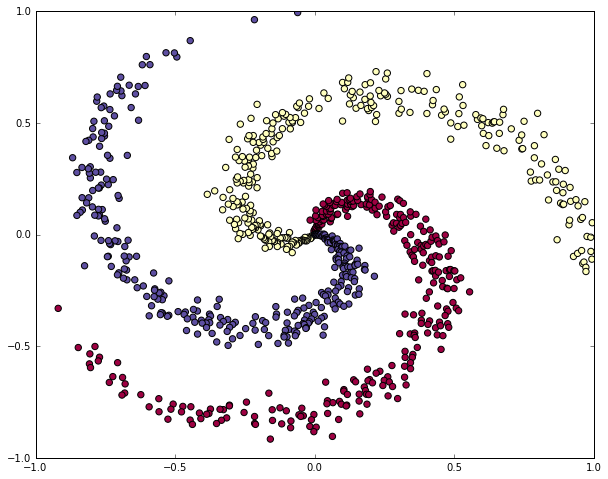

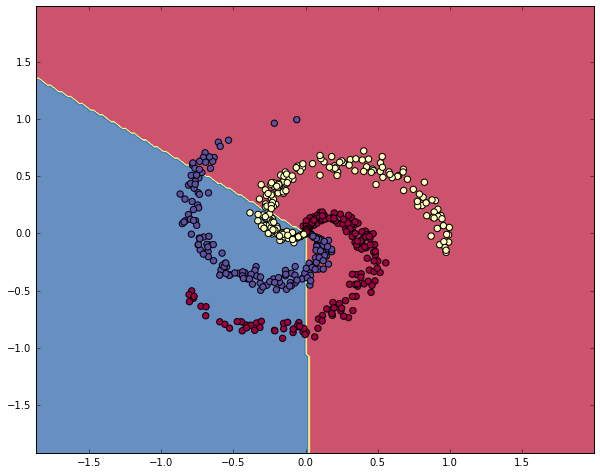

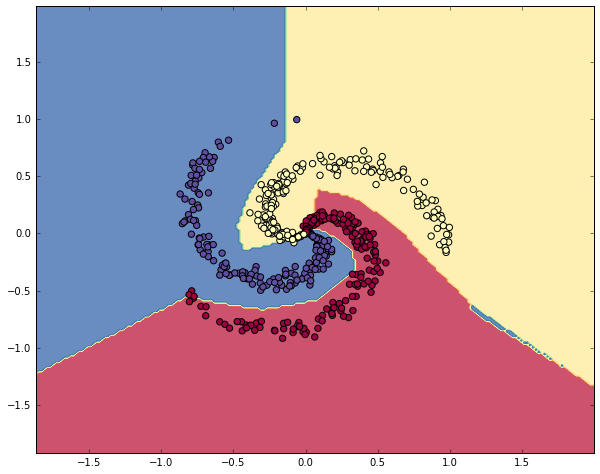

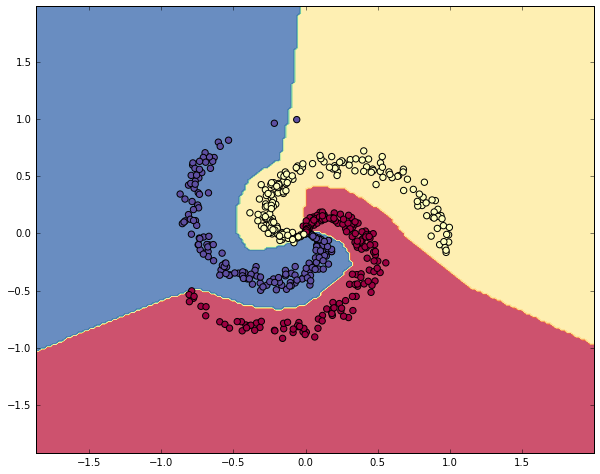

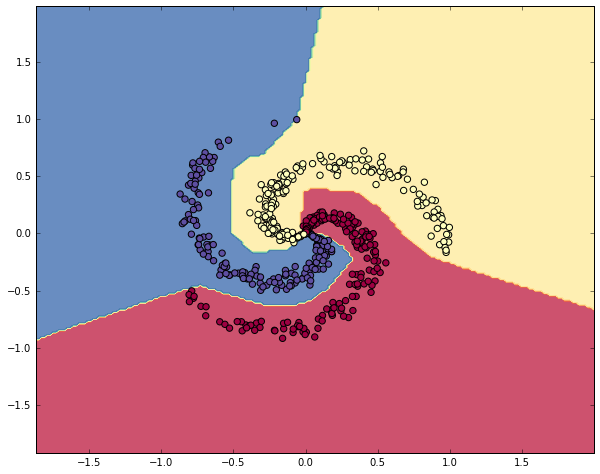

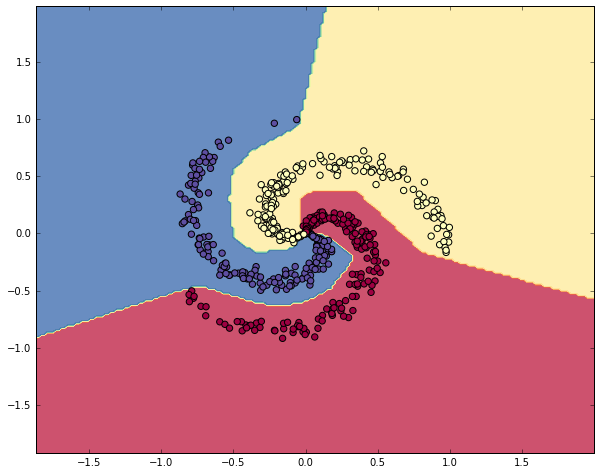

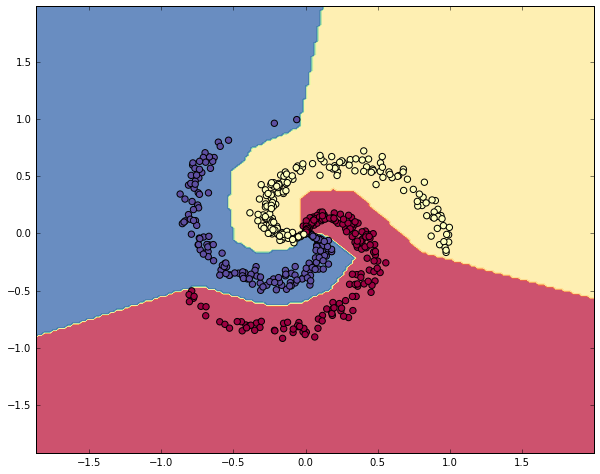

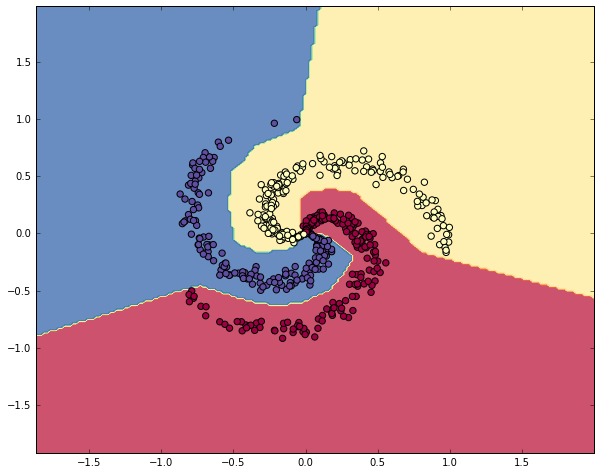

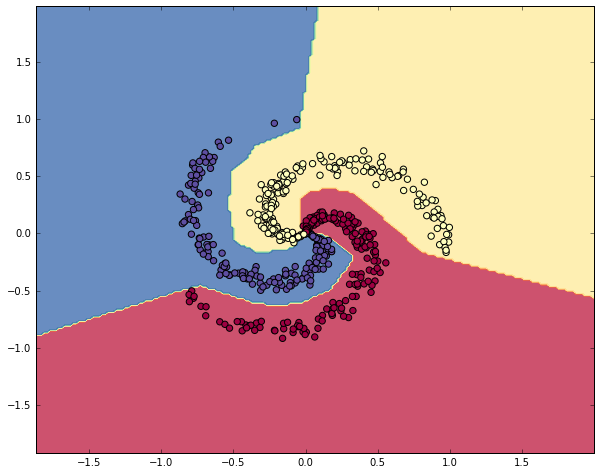

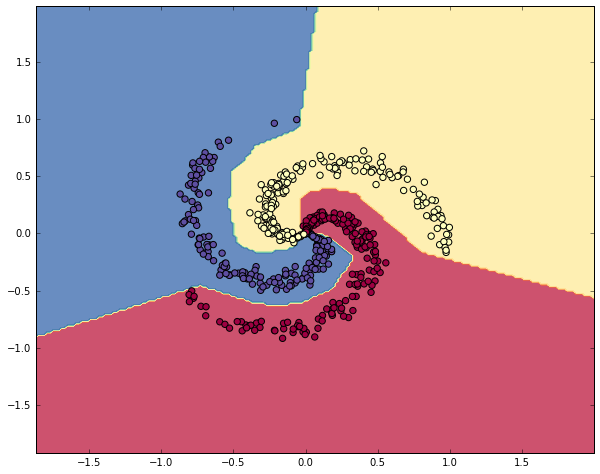

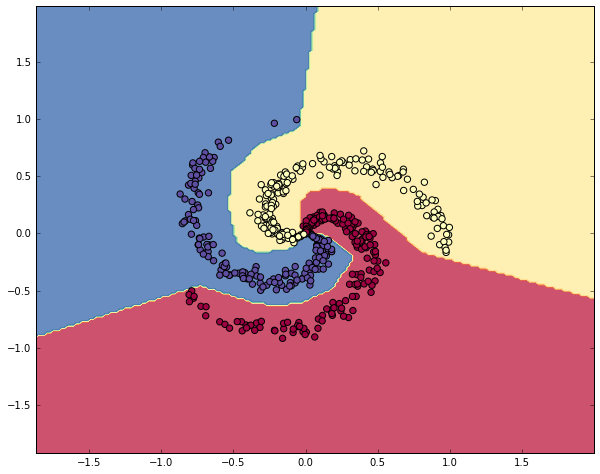

In [14]:
X,y = generateSpiralData()
trainD, trainL, valD, valL, testD, testL = splitSpiralData(X,y)
W1,b1,W2,b2 = trainNN(trainD,trainL)

In [15]:
# test on valDataSet
valLayer1 = np.maximum(0, np.dot(valD, W1) + b1)
valLayer2 = np.dot(valLayer1, W2) + b2
predicted_class = np.argmax(valLayer2, axis = 1)
print('validation accuracy: %.4f' % (np.mean(predicted_class == valL)))

validation accuracy: 0.9889


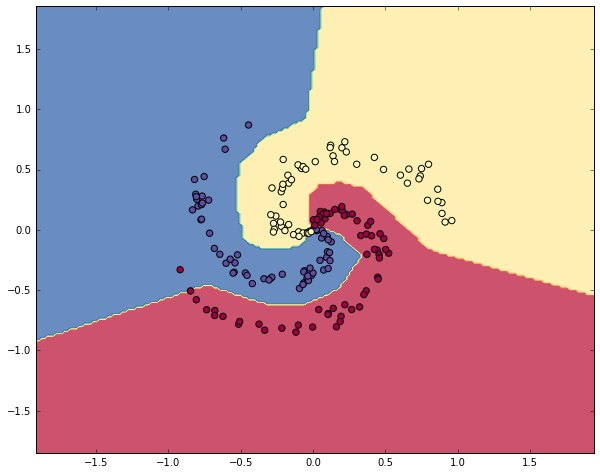

In [16]:
# plot the resulting classifier
plotDataAndBoundary(valD,valL,W1,b1,W2,b2,fileName='spiralVal.png')